# Perceptual Beat Estimator Test Procedure

#### Import required functions

In [12]:
from midi_utils import midi2string, midiTrack2OnsetTimes, pbeFromOnsets
from PerceptualBeatEstimator import PerceptualBeatEstimator
from mido import MidiFile
import numpy as np
import matplotlib.pyplot as plt

### Latency testing (what is the best value of latency correction?)
There is a delay between the drum being hit and bonk detecting an onset.
We must account for this delay by subtracting some amount from the onset times.
Begin by trying latency corrections between 0 and 30ms (inclusive).

### Test sets stored in midi files
Each recorded test is stored on a different track in one midi file. The onsets are in one midi file, and the perceptual beats are in another. The perceptual beats corresponding to a set of onsets are stored in the same track number as the onsets.

In [27]:
test_dir = 'test_sets/set_2/'

onsets = MidiFile(test_dir+'onsets.mid')  # midi file of onsets
pb = MidiFile(test_dir+'pb.mid')

total_errors = []
arr_errors = []  # list of errors for each parameter permutation
for i, zipped in enumerate(zip(onsets.tracks,pb.tracks)):
    onsets_track = zipped[0]
    pb_track = zipped[1]
    
    if i==0:
        continue
    
    # 1. Extract info about the performance stored in the track name
    trackInfo = (onsets_track.name).split(',')
    patternName = trackInfo[0]
    Nb = int(trackInfo[1][trackInfo[1].index('=')+1:])
    beat_div = int(trackInfo[2][trackInfo[2].index('=')+1:])
    
    # 2. Get a pbe object for the performance stored in the onsets track
    pbe = pbeFromOnsets(onsets_track, Nb=Nb, beat_div=beat_div)
    
    # 3. Get time predictions
    t_next_beat, bp_next_beat = pbe.getPredictions()
    t_pb = list([0 for _ in range(Nb)]) + midiTrack2OnsetTimes(pb_track)
    bp_pb = list(range(1,len(t_pb)+1))
    
    # 4. Compare times
    track_errors = []  # list of error in prediction time at each onset
    for j in range(1, len(t_next_beat)):  # loop through recorded onsets. skip the first onset
        predicted_time = t_pb[bp_next_beat[j]-1]
        # the first perceptual beat occurs adter the synchronising beats
            # E.g. in the case of 4/4, first pb and therefore first comparision is at BP=5.
        if predicted_time:    # True if a perceptual beat was recorded at BP = bp_next_beat[j] -> False if 0
            track_errors.append(t_next_beat[j] - predicted_time)
    total_errors.append(track_errors)

total_errors_flat=[]
for track_errors in total_errors:
    total_errors_flat.extend(track_errors)
    print(track_errors[0:5])
    
arr_errors.append(total_errors_flat)
    


[-0.05837006717043991, -0.04306840311586857, -0.01480692993407029, 0.0024805625130399633, 0.014277123316179363]
[-0.03801912940749208, -0.04739203273431691, -0.0571077994121314, -0.06788549357911489, -0.03516266852569405]
[-0.02207307821983484, -0.028527685594885277, -0.0005853942610745122, -0.04355214247553185, -0.04609720289622388]
[-0.008465495679849777, -0.0293499818049483, -0.046745031755791366, -0.05964303118908898, -0.03955058713096715]
[-0.013307427654480897, -0.0329591669399818, -0.04491839607338477, -0.05178503743011342, -0.030950129235470136]
[-0.05837006717043991, -0.04306840311586857, -0.01480692993407029, 0.0024805625130399633, 0.014277123316179363, -0.006645342841668622, -0.003322988505750857, 0.004013403990068554, 0.008240693148486855, 0.015618385193423734]


### Latency correction test

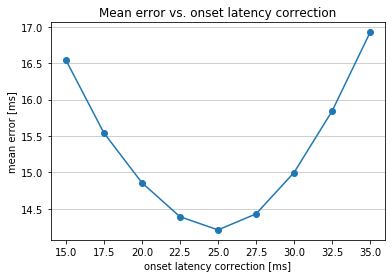

In [13]:
test_dir = 'test_sets/set_2/'

onsets = MidiFile(test_dir+'onsets.mid')  # midi file of onsets
pb = MidiFile(test_dir+'pb.mid')

# Latency parameters
latency_range = (np.arange(15/1000, 35/1000, 2.5/1000)) # 0 - 30ms in steps of 5ms

arr_errors = []  # list of errors for each parameter permutation
for delta_latency in latency_range:
    total_errors = []
    for i, zipped in enumerate(zip(onsets.tracks,pb.tracks)):
        onsets_track = zipped[0]
        pb_track = zipped[1]

        if i==0:
            continue

        # 1. Extract info about the performance stored in the track name
        trackInfo = (onsets_track.name).split(',')
        patternName = trackInfo[0]
        Nb = int(trackInfo[1][trackInfo[1].index('=')+1:])
        beat_div = int(trackInfo[2][trackInfo[2].index('=')+1:])

        # 2. Get a pbe object for the performance stored in the onsets track
        pbe = pbeFromOnsets(onsets_track, Nb=Nb, beat_div=beat_div, delta_latency=delta_latency)

        # 3. Get time predictions
        t_next_beat, bp_next_beat = pbe.getPredictions()
        t_pb = list([0 for _ in range(Nb)]) + midiTrack2OnsetTimes(pb_track)
        bp_pb = list(range(1,len(t_pb)+1))

        # 4. Compare times
        track_errors = []  # list of error in prediction time at each onset
        for j in range(1, len(t_next_beat)):  # loop through recorded onsets. skip the first onset
            predicted_time = t_pb[bp_next_beat[j]-1]
            # the first perceptual beat occurs adter the synchronising beats
                # E.g. in the case of 4/4, first pb and therefore first comparision is at BP=5.
            if predicted_time:    # True if a perceptual beat was recorded at BP = bp_next_beat[j] -> False if 0
                track_errors.append(t_next_beat[j] - predicted_time)
        total_errors.append(track_errors)

    total_errors_flat=[]
    for track_errors in total_errors:
        total_errors_flat.extend(track_errors)
    
    # record the total errors for this value of delta_latency
    arr_errors.append(total_errors_flat)

# plot mean (absolute) error vs. delta latency
means = []
for errors in arr_errors:
    means.append(np.mean(np.abs(np.array(errors))))
    
plt.figure()
plt.title('Mean error vs. onset latency correction')
plt.xlabel('onset latency correction [ms]')
plt.ylabel('mean error [ms]')
plt.grid(axis='y', alpha=0.75)
plt.plot(np.array(latency_range)*1000, np.array(means)*1000, '-o')


### BP Window width test


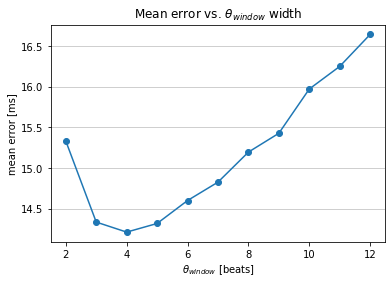

In [48]:
test_dir = 'test_sets/set_2/'

onsets = MidiFile(test_dir+'onsets.mid')  # midi file of onsets
pb = MidiFile(test_dir+'pb.mid')

# BP window parameters
BP_window_range = range(2,13)

arr_errors = []  # list of errors for each parameter permutation
for BP_window in BP_window_range:
    total_errors = []
    for i, zipped in enumerate(zip(onsets.tracks,pb.tracks)):
        onsets_track = zipped[0]
        pb_track = zipped[1]

        if i==0:
            continue

        # 1. Extract info about the performance stored in the track name
        trackInfo = (onsets_track.name).split(',')
        patternName = trackInfo[0]
        Nb = int(trackInfo[1][trackInfo[1].index('=')+1:])
        beat_div = int(trackInfo[2][trackInfo[2].index('=')+1:])

        # 2. Get a pbe object for the performance stored in the onsets track
        pbe = pbeFromOnsets(onsets_track, Nb=Nb, beat_div=beat_div, BP_window=BP_window, delta_latency=0.025)

        # 3. Get time predictions
        t_next_beat, bp_next_beat = pbe.getPredictions()
        t_pb = list([0 for _ in range(Nb)]) + midiTrack2OnsetTimes(pb_track)
        bp_pb = list(range(1,len(t_pb)+1))

        # 4. Compare times
        track_errors = []  # list of error in prediction time at each onset
        for j in range(1, len(t_next_beat)):  # loop through recorded onsets. skip the first onset
            predicted_time = t_pb[bp_next_beat[j]-1]
            # the first perceptual beat occurs adter the synchronising beats
                # E.g. in the case of 4/4, first pb and therefore first comparision is at BP=5.
            if predicted_time:    # True if a perceptual beat was recorded at BP = bp_next_beat[j] -> False if 0
                track_errors.append(t_next_beat[j] - predicted_time)
        total_errors.append(track_errors)

    total_errors_flat=[]
    for track_errors in total_errors:
        total_errors_flat.extend(track_errors)
    
    # record the total errors for this value of delta_latency
    arr_errors.append(total_errors_flat)

# plot mean (absolute) error vs. delta latency
means = []
for errors in arr_errors:
    means.append(np.mean(np.abs(np.array(errors))))
    
plt.figure()
plt.title(r'Mean error vs. $\theta_{window}$ width')
plt.xlabel(r'$\theta_{window}$ [beats]')
plt.ylabel('mean error [ms]')
plt.grid(axis='y', alpha=0.75)
plt.plot(BP_window_range, np.array(means)*1000, '-o')
plt.show()